In [18]:
import os
import sys
import warnings

sys.path.append("..")
warnings.filterwarnings("ignore")

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("default")
from tqdm import tqdm

from src.dataset import preprocess

In [2]:
preds = np.load("../output/sample_00.npy")

In [3]:
stock = {}
# folder_path = "/raid/data/abner/tw_stock_data"
folder_path = "/raid/tw_stock_data"

for _, path in tqdm(
    enumerate(glob(f"{folder_path}/*.csv"))
):
    curr_df = pd.read_csv(path)
    stock_name = os.path.basename(path).split(".")[0]

    if len(curr_df) >= 4000:
        stock[stock_name] = curr_df

subset = stock
shortest_seq = min([len(v) for v in subset.values()])

16it [00:00, 156.05it/s]

1087it [00:04, 235.65it/s]


In [29]:
## calculate 10d cumret
window = 10
all_stocks = {}
single_ret = {}
for stock_id, stock_data in tqdm(subset.items()):
    stock_data['ret'] = stock_data['收盤價'].pct_change().fillna(0)
    single_ret[stock_id] = stock_data['ret']

    sequence = stock_data['ret']
    avg_rets = [None] * int(len(sequence) / window)

    for i in range(int(len(sequence) / window)):
        next_window_ret = sequence[i: i + window].values
        avg_rets[i] = next_window_ret.sum()

    avg_rets = pd.Series(avg_rets).fillna(0)
    all_stocks[stock_id] = avg_rets

all_stocks_df = pd.DataFrame(all_stocks).fillna(0)

100%|██████████| 606/606 [00:05<00:00, 120.22it/s]


In [30]:
single_ret_df = pd.DataFrame(single_ret).fillna(0)

In [40]:
single_ret_negs_count = single_ret_df[single_ret_df < 0].count(axis=1)
single_ret_pos_count = single_ret_df[single_ret_df > 0].count(axis=1)

In [41]:
single_ret_negs_count_percentage = single_ret_negs_count / single_ret_df.shape[1]
single_ret_pos_count_percentage = single_ret_pos_count / single_ret_df.shape[1]


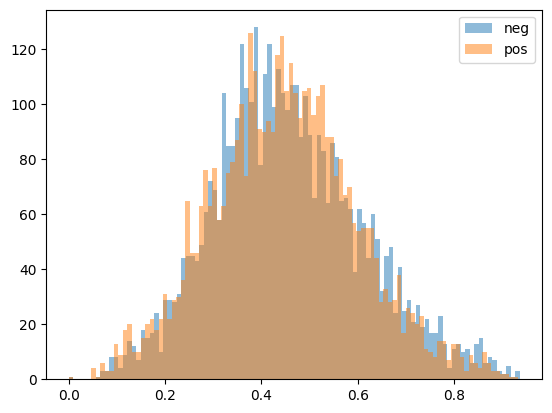

In [54]:
plt.hist(single_ret_negs_count_percentage, bins=100, alpha=0.5, label="neg")
plt.hist(single_ret_pos_count_percentage, bins=100, alpha=0.5, label="pos")
plt.legend()

In [57]:
single_ret_negs_count_percentage.min()

0.0

In [58]:
def preprocess(stock_dict):
    for stock_id, stock_data in tqdm(stock_dict.items()):
        stock_data['ret'] = stock_data['收盤價'].pct_change().fillna(0)
        stock_dict[stock_id] = stock_data

    return stock_dict


def get_returns(stock_dict, shortest_seq):
    return_matrix_list = []

    for i in tqdm(range(1500, shortest_seq, 125)):
        if i + 125 > shortest_seq:
            break

        return_matrix = np.zeros((125, 606))

        for j, (_, stock_df) in enumerate(stock_dict.items()):
            return_matrix[:, j] = stock_df.iloc[i: i + 125]["ret"].values

        return_matrix_list.append(return_matrix)

    return return_matrix_list

In [59]:
# subset = preprocess(subset, "cumret", 10, "pos")
subset = preprocess(subset)
return_matrix_list = get_returns(subset, shortest_seq)

 95%|█████████▌| 20/21 [00:00<00:00, 21.51it/s]


In [61]:
return_matrix_arr = np.array(return_matrix_list)[:8]

In [62]:
print(preds.shape, return_matrix_arr.shape)

(8, 125, 606, 10) (8, 125, 606)


In [63]:
sample_alpha = preds[1, 10, :, :] # (606, 10)
sample_ret = return_matrix_arr[1, 10:20, :] # (10, 606)
cumret = sample_ret.cumsum(axis=0)[-1] # (606, )
desc_cumret_index = np.argsort(cumret)[::-1] # (606, )
desc_alpha_index = np.argsort(sample_alpha, axis=0)[::-1] # (606, 10)

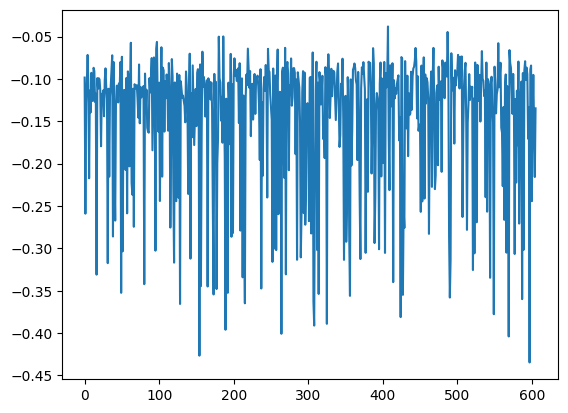

In [69]:
plt.plot(sample_alpha[:, 0])

<Figure size 1500x500 with 0 Axes>

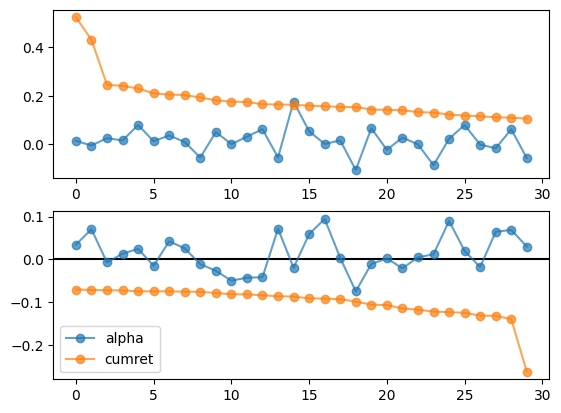

In [66]:
a=2
w=30
plt.figure(figsize=(15, 5))
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(cumret[desc_alpha_index[:, a]][:w], marker="o", alpha=0.7, label="alpha")
ax1.plot(cumret[desc_cumret_index][:w], marker="o", alpha=0.7, label="cumret")
ax2.axhline(y=0.0, color="black")
ax2.plot(cumret[desc_alpha_index[:, a]][-w:], marker="o", alpha=0.7, label="alpha")
ax2.plot(cumret[desc_cumret_index][-w:], marker="o", alpha=0.7, label="cumret")
plt.legend()

In [70]:
steps, test_days, n_stocks, n_alphas = preds.shape

In [80]:
long_returns, short_returns, bench_returns = np.zeros((steps, test_days)), np.zeros((steps, test_days)), np.zeros((steps, test_days))
top_k, bottom_k = 50, 50


for step in tqdm(range(steps)):
    this_step_alphas = preds[step]
    this_step_return = return_matrix_arr[step]

    for day in range(0, test_days, 10):
        time_range = 10 if day + 10 < test_days else test_days - day
        this_day_alphas = this_step_alphas[day]
        n_alphas = this_day_alphas.shape[-1]
        top_k_indices, top_k_alphas = np.zeros((top_k, n_alphas), dtype=int), np.zeros((top_k, n_alphas))
        bottom_k_indices, bottom_k_alphas = np.zeros((bottom_k, n_alphas), dtype=int), np.zeros((bottom_k, n_alphas))

        for alpha_idx in range(n_alphas):
            sorted_indices = np.argsort(this_day_alphas[:, alpha_idx])[::-1]
            top_k_indices[:, alpha_idx], bottom_k_indices[:, alpha_idx] = sorted_indices[:top_k], sorted_indices[-bottom_k:]
            top_k_alphas[:, alpha_idx], bottom_k_alphas[:, alpha_idx] = this_day_alphas[sorted_indices[:top_k], alpha_idx], this_day_alphas[sorted_indices[-bottom_k:], alpha_idx]

        flat_top_indices, flat_bottom_indices = top_k_indices.flatten(), bottom_k_indices.flatten()
        flat_top_alphas, flat_bottom_alphas = top_k_alphas.flatten(), bottom_k_alphas.flatten()

        unique_top_stocks, unique_bottom_stocks = np.unique(flat_top_indices), np.unique(flat_bottom_indices)

        day_top_ret, day_bottom_ret = [], []
        
        for stock in unique_top_stocks:
            positions = np.where(flat_top_indices == stock)[0]
            alpha_values = np.sum(flat_top_alphas[positions])
            target_return_sequence = this_step_return[day: day + time_range, stock]
            day_top_ret.append(target_return_sequence * alpha_values)

        day_top_ret = np.sum(np.array(day_top_ret), axis=0) / (top_k * n_alphas)
        long_returns[step, day: day + time_range] = target_return_sequence * alpha_values

        for stock in unique_bottom_stocks:
            positions = np.where(flat_bottom_indices == stock)[0]
            alpha_values = np.sum(flat_bottom_alphas[positions])
            target_return_sequence = this_step_return[day: day + time_range, stock]
            day_bottom_ret.append(target_return_sequence * alpha_values)

        day_bottom_ret = np.sum(np.array(day_bottom_ret), axis=0) / (bottom_k * n_alphas)
        short_returns[step, day: day + time_range] = target_return_sequence * alpha_values

100%|██████████| 8/8 [00:00<00:00, 31.96it/s]


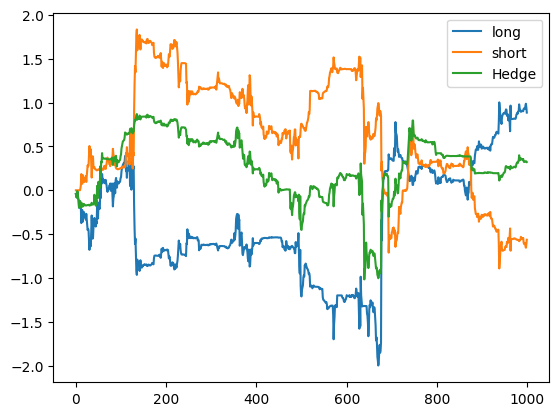

In [81]:
plt.plot(long_returns.flatten().cumsum(), label="long")
plt.plot(short_returns.flatten().cumsum(), label="short")
plt.plot(long_returns.flatten().cumsum() + short_returns.flatten().cumsum(), label="Hedge")
plt.legend()